In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
with open('/content/drive/My Drive/MLSec/WiFi-Data.txt','r') as f: # to test my code, please change this directory to the directory which contains data in your drive
    data=f.readlines()

data_arr=np.array([l.rstrip('\n').split('\t') for l in data]).astype(np.int)
np.random.shuffle(data_arr)

In [ ]:
# selecting regions 1 and 3
data_1_3=np.array([l for l in data_arr if l[7]==1 or l[7]==3])
np.random.shuffle(data_1_3)
train_data=data_1_3[:int(len(data_1_3)*0.8)]
test_data=data_1_3[len(train_data):]

###Training

In [ ]:
def softmax(z): # since data is all negative, I did not subtract form max
    N=np.shape(z)[0]
    exps = np.exp(z-np.max(z))
    t=np.tile(np.reshape(np.sum(exps,axis=1),(N,1)),np.shape(z)[1])
    probs=np.clip(exps / t, 1e-6,1-1e-6)
    return probs

def onehot(Y): #Y is a vector with length N whose elements are the real labels
    N=len(Y)
    Y_transformed=np.maximum(np.zeros(N),Y-2).astype(int) # to convert label 1 into 0, and label 3 into 1
    onehot=np.zeros((N,2))
    range=np.arange(N)
    onehot[range,Y_transformed]=1
    return onehot

def loss(probs,Y,w,reg_coef):
    loss=np.mean(np.sum(-np.log(probs)*Y,axis=1)) + reg_coef*np.sum(w**2)
    return loss
    
def train_1_3(data,iters,lr,reg_coef):
    N=np.shape(data)[0]
    w=np.zeros((2,8)) #baises are the last column of wights
    b=0
    X_t=data[:,:7]
    z=np.ones((N,1))
    X=np.concatenate((X_t,z),axis=1)
    Y_t=data[:,7]
    Y=onehot(Y_t) # Y shape: [N,2]

    losses=[]
    for i in range(iters):
        linear=np.matmul(X,w.T)
        probs=softmax(linear) # probs shape: [N,2]
        losses.append(loss(probs,Y,w, reg_coef))
        w_grad=(1/N)*np.matmul((probs-Y).T,X) + 2*reg_coef*w
        w=w-(lr*w_grad)

    return w,losses

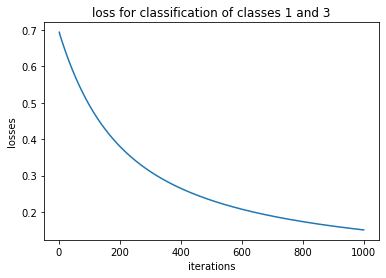

In [ ]:
iters=1000
lr=0.0001
regulatization_coef=0 # here were do not use regularization
w,losses=train_1_3(train_data,iters,lr,regulatization_coef)
plt.plot(np.arange(1,iters+1),losses)
plt.xlabel('iterations')
plt.ylabel('losses')
plt.title('loss for classification of classes 1 and 3')
plt.show()

###Test

In [ ]:
def acc_on_test(data,w):
    N=np.shape(data)[0]
    X_t=data[:,:7]
    z=np.ones((N,1))
    X=np.concatenate((X_t,z),axis=1)
    Y=data[:,7]
    probes=softmax(np.matmul(X,w.T))
    predictions=np.argmax(probes, axis=1)
    predicted_labels=(predictions*2)+1 # to convert back 0,1 to 1,3
    return Y,predicted_labels, (np.sum(predicted_labels==Y)/N)*100

In [ ]:
Y,preds, accuracy= acc_on_test(test_data,w)
print("accuracy on test:",accuracy)

accuracy on test: 98.5


### Confusion Matrix

In [ ]:
def confusion_matrix(Y, preds):
    one_one=one_three=three_one=three_three=0  #the first word is for Y, the second for prediction. Therefore one_three counts the number of inputes whose real label were one, but were predicted as three.
    for i in range(len(Y)):
        if Y[i]==1 and preds[i]==1:
            one_one+=1
        if Y[i]==1 and preds[i]==3:
            one_three+=1
        if Y[i]==3 and preds[i]==1:
            three_one+=1
        if Y[i]==3 and preds[i]==3:
            three_three+=1
    return [[one_one,three_one],[one_three,three_three]]


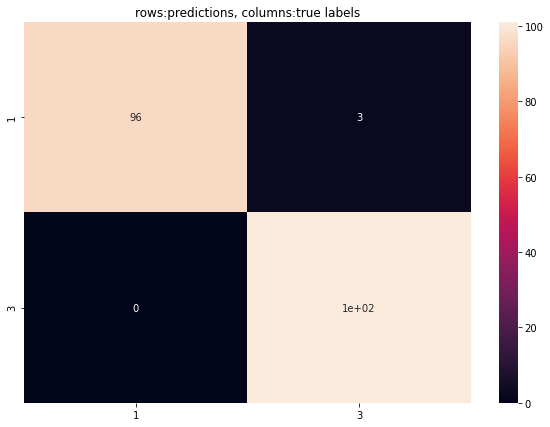

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
def plot_conf_mat(array):
    df_cm = pd.DataFrame(array, index = [i for i in "13"],columns = [i for i in "13"])
    plt.figure(figsize = (10,7))
    plt.title("rows:predictions, columns:true labels")
    sn.heatmap(df_cm, annot=True)

plot_conf_mat(confusion_matrix(Y,preds))

###comparing losses for differect regularization coefficients including zero (part a)

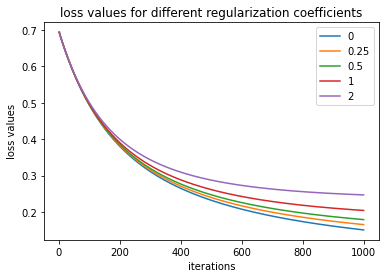

In [ ]:
iters=1000
lr=0.0001
w,losses=train_1_3(train_data,iters,lr,reg_coef=0)
w_1,losses_1=train_1_3(train_data,iters,lr,reg_coef=0.25)
w_2,losses_2=train_1_3(train_data,iters,lr,reg_coef=0.5)
w_3,losses_3=train_1_3(train_data,iters,lr,reg_coef=1)
w_4,losses_4=train_1_3(train_data,iters,lr,reg_coef=2)

plt.plot(np.arange(1,iters+1),losses,label='0')
plt.plot(np.arange(1,iters+1),losses_1,label='0.25')
plt.plot(np.arange(1,iters+1),losses_2,label='0.5')
plt.plot(np.arange(1,iters+1),losses_3,label='1')
plt.plot(np.arange(1,iters+1),losses_4,label='2')
plt.xlabel('iterations')
plt.ylabel('loss values')
plt.title('loss values for different regularization coefficients')
plt.legend()
plt.show()

###Accuracy on test data and confusion matrix for each regularization coef

coef=0.25
accuracy on test: 98.5
coef=0.5
accuracy on test: 98.5
coef=1
accuracy on test: 98.5
coef=2
accuracy on test: 98.5


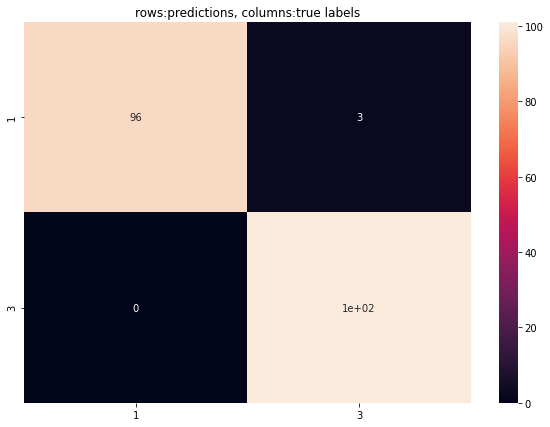

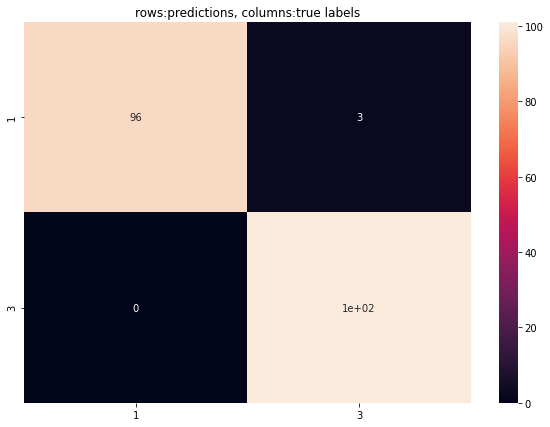

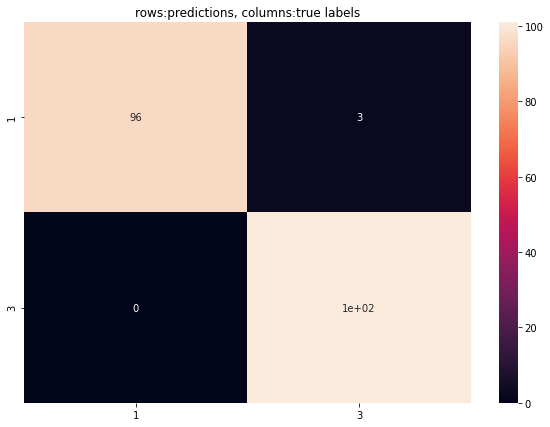

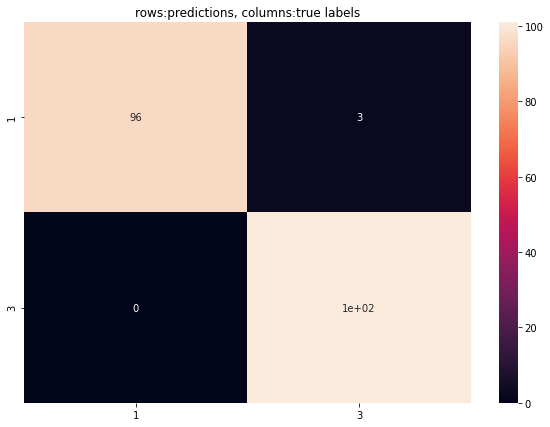

In [ ]:
print("coef=0.25")
Y_1,preds_1, accuracy_1= acc_on_test(test_data,w_1)
print("accuracy on test:",accuracy_1)
plot_conf_mat(confusion_matrix(Y_1,preds_1))

print("coef=0.5")
Y_2,preds_2, accuracy_2= acc_on_test(test_data,w_2)
print("accuracy on test:",accuracy_2)
plot_conf_mat(confusion_matrix(Y_2,preds_2))

print("coef=1")
Y_3,preds_3, accuracy_3= acc_on_test(test_data,w_3)
print("accuracy on test:",accuracy_3)
plot_conf_mat(confusion_matrix(Y_3,preds_3))

print("coef=2")
Y_4,preds_4, accuracy_4= acc_on_test(test_data,w_4)
print("accuracy on test:",accuracy_4)
plot_conf_mat(confusion_matrix(Y_4,preds_4))

It seems that regularization coefficients do not influence the results much in this problem. It is probably because the data itself is in good shape and the weights that are learned without regularization are very good weights themselves (good in the sense that they have good generalization properties as they perform very well on the test data), so adding regularization to loss function, increases it in the last iterations as seen by the plot. The good weights learned using the cross-entropy loss provide high accuracy on test data in all cases.

### Classifying 4 classes

In [ ]:
train_data_4=data_arr[:int(0.8*(data_arr.shape[0]))]
test_data_4=data_arr[int(0.8*(data_arr.shape[0])):]

In [ ]:
def softmax(z): # since the data is all negative, I did not subtract form max
    N=np.shape(z)[0]
    exps = np.exp(z-np.max(z))
    t=np.tile(np.reshape(np.sum(exps,axis=1),(N,1)),np.shape(z)[1])
    probs=np.clip(exps / t, 1e-6,1-1e-6)
    return probs

def onehot(Y): #Y is a vector with length N whose elements are the real labels
    N=len(Y)
    Y_transformed=Y-1 # to convert label 1 into 0, and label 3 into 1
    onehot=np.zeros((N,4))
    range=np.arange(N)
    onehot[range,Y_transformed]=1
    return onehot

def loss(probs,Y,w,reg_coef,mode):
    if mode==1:
        loss=np.mean(np.sum(-np.log(probs)*Y,axis=1)) + reg_coef*np.sum(np.absolute(w))
    else:
        loss=np.mean(np.sum(-np.log(probs)*Y,axis=1)) + reg_coef*np.sum(w**2)

    return loss
    
def train_all(data,iters,lr,reg_coef, mode): #mode=1 means we are using l1 regularizer, and mode=2 means we are using l2.
    N=np.shape(data)[0]
    w=np.zeros((4,8)) #baises are the last column of wights
    b=0
    X_t=data[:,:7]
    z=np.ones((N,1))
    X=np.concatenate((X_t,z),axis=1)
    Y_t=data[:,7]
    Y=onehot(Y_t) # Y shape: [N,4]

    losses=[]
    for i in range(iters):
        linear=np.matmul(X,w.T)
        probs=softmax(linear) # probs shape: [N,4]
        losses.append(loss(probs,Y,w, reg_coef,mode))
        if mode==1:
            w_grad=(1/N)*np.matmul((probs-Y).T,X) + reg_coef*np.sign(w)
        else:
            w_grad=(1/N)*np.matmul((probs-Y).T,X) + 2*reg_coef*w
        w=w-(lr*w_grad)

    return w,losses


###  l1 *regularizer*

Training

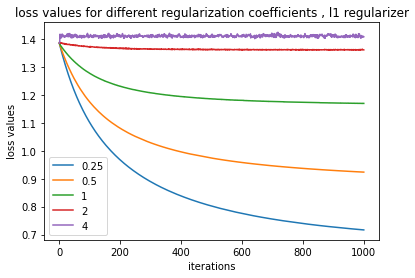

In [ ]:
iters=1000
lr=0.0001
w_1,losses_1=train_all(train_data_4,iters,lr,0.25,mode=1)
w_2,losses_2=train_all(train_data_4,iters,lr,0.5,mode=1)
w_3,losses_3=train_all(train_data_4,iters,lr,1,mode=1)
w_4,losses_4=train_all(train_data_4,iters,lr,2,mode=1)
w_5,losses_5=train_all(train_data_4,iters,lr,4,mode=1)

plt.plot(np.arange(1,iters+1),losses_1,label='0.25')
plt.plot(np.arange(1,iters+1),losses_2,label='0.5')
plt.plot(np.arange(1,iters+1),losses_3,label='1')
plt.plot(np.arange(1,iters+1),losses_4,label='2')
plt.plot(np.arange(1,iters+1),losses_5,label='4')
plt.xlabel('iterations')
plt.ylabel('loss values')
plt.title('loss values for different regularization coefficients , l1 regularizer')
plt.legend()
plt.show()

Test

In [ ]:
def acc_on_test_all(data,w):
    N=np.shape(data)[0]
    X_t=data[:,:7]
    z=np.ones((N,1))
    X=np.concatenate((X_t,z),axis=1)
    Y=data[:,7]
    probes=softmax(np.matmul(X,w.T))
    predictions=np.argmax(probes, axis=1)
    predicted_labels=predictions+1 # to convert back 0,1 to 1,3
    return Y,predicted_labels, (np.sum(predicted_labels==Y)/N)*100

In [ ]:
def confusion_matrix_all(Y, preds):
    matrix=np.zeros([4,4])
    Y=Y-1
    preds=preds-1
    for i in range(len(Y)):
        matrix[Y[i],preds[i]]+=1
    return matrix.T

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
def plot_conf_mat_all(array):
    df_cm = pd.DataFrame(array, index = [i for i in "1234"],columns = [i for i in "1234"])
    plt.figure(figsize = (10,7))
    plt.title("rows:predictions, columns:true labels")
    sn.heatmap(df_cm, annot=True)

coef=0.25
accuracy on test: 97.25
coef=0.5
accuracy on test: 95.75
coef=1
accuracy on test: 89.5
coef=2
accuracy on test: 71.75
coef=4
accuracy on test: 23.25


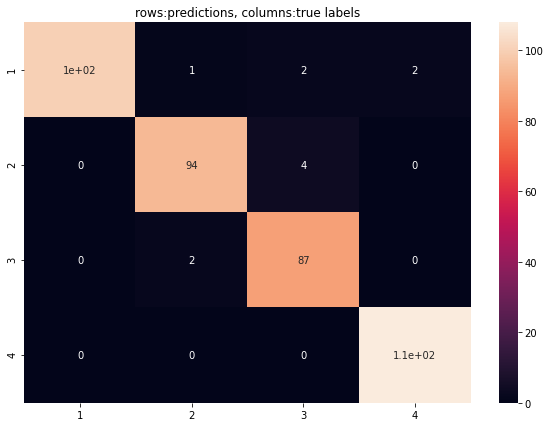

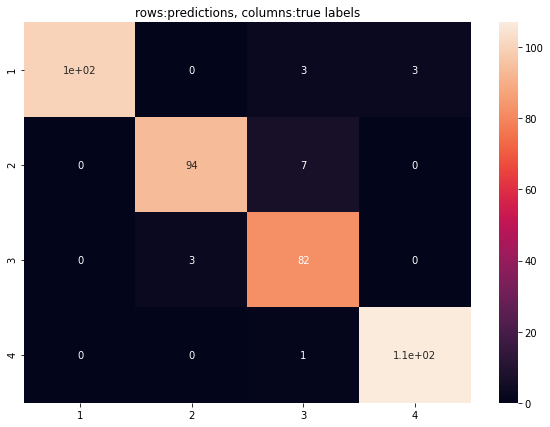

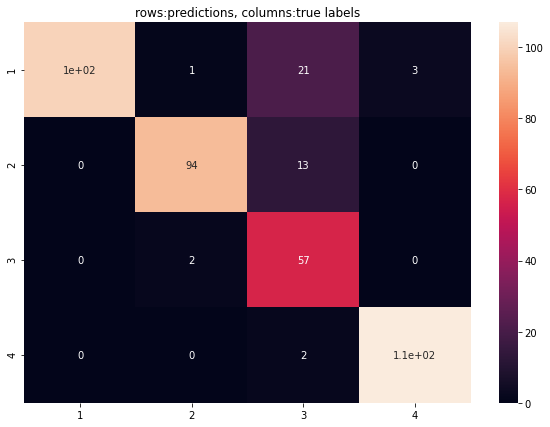

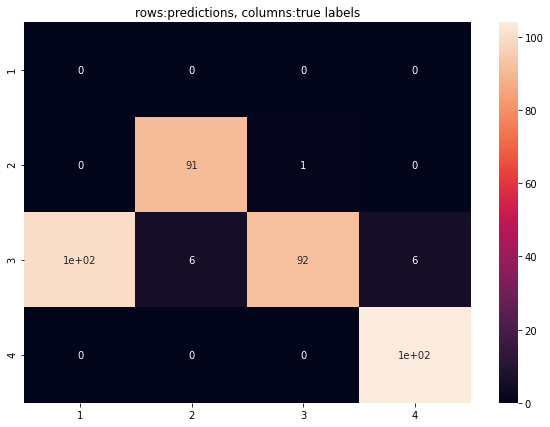

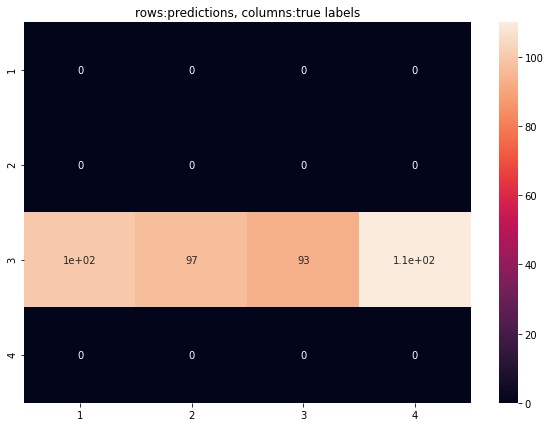

In [ ]:
print("coef=0.25")
Y_1,preds_1, accuracy_1= acc_on_test_all(test_data_4,w_1)
print("accuracy on test:",accuracy_1)
plot_conf_mat_all(confusion_matrix_all(Y_1,preds_1))

print("coef=0.5")
Y_2,preds_2, accuracy_2= acc_on_test_all(test_data_4,w_2)
print("accuracy on test:",accuracy_2)
plot_conf_mat_all(confusion_matrix_all(Y_2,preds_2))

print("coef=1")
Y_3,preds_3, accuracy_3= acc_on_test_all(test_data_4,w_3)
print("accuracy on test:",accuracy_3)
plot_conf_mat_all(confusion_matrix_all(Y_3,preds_3))

print("coef=2")
Y_4,preds_4, accuracy_4= acc_on_test_all(test_data_4,w_4)
print("accuracy on test:",accuracy_4)
plot_conf_mat_all(confusion_matrix_all(Y_4,preds_4))

print("coef=4")
Y_5,preds_5, accuracy_5= acc_on_test_all(test_data_4,w_5)
print("accuracy on test:",accuracy_5)
plot_conf_mat_all(confusion_matrix_all(Y_5,preds_5))

###L2 regularizer

Training

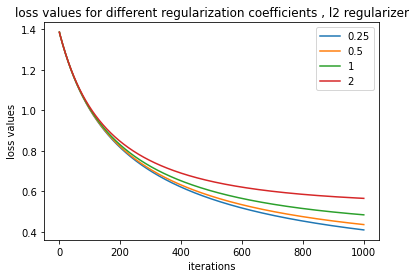

In [ ]:
iters=1000
lr=0.0001
w_1_,losses_1_=train_all(train_data_4,iters,lr,0.25,mode=2)
w_2_,losses_2_=train_all(train_data_4,iters,lr,0.5,mode=2)
w_3_,losses_3_=train_all(train_data_4,iters,lr,1,mode=2)
w_4_,losses_4_=train_all(train_data_4,iters,lr,2,mode=2)

plt.plot(np.arange(1,iters+1),losses_1_,label='0.25')
plt.plot(np.arange(1,iters+1),losses_2_,label='0.5')
plt.plot(np.arange(1,iters+1),losses_3_,label='1')
plt.plot(np.arange(1,iters+1),losses_4_,label='2')

plt.xlabel('iterations')
plt.ylabel('loss values')
plt.title('loss values for different regularization coefficients , l2 regularizer')
plt.legend()
plt.show()


Test

coef=0.25
accuracy on test: 97.25
coef=0.5
accuracy on test: 97.25
coef=1
accuracy on test: 97.25
coef=2
accuracy on test: 97.25


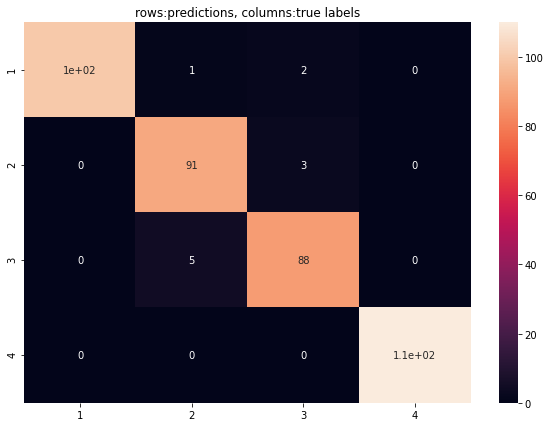

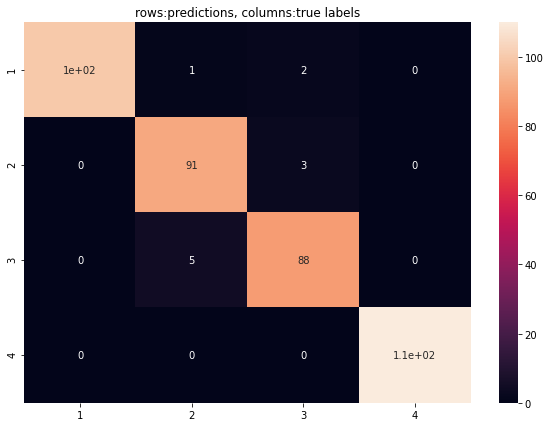

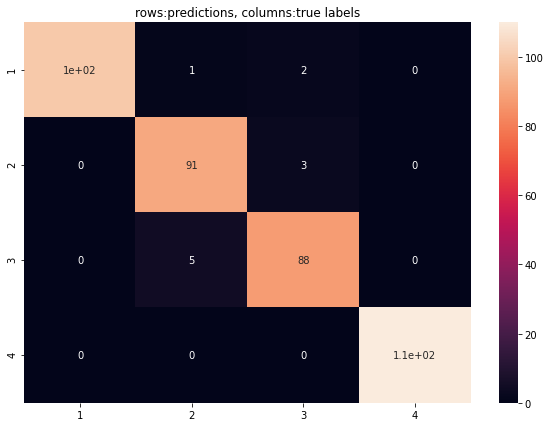

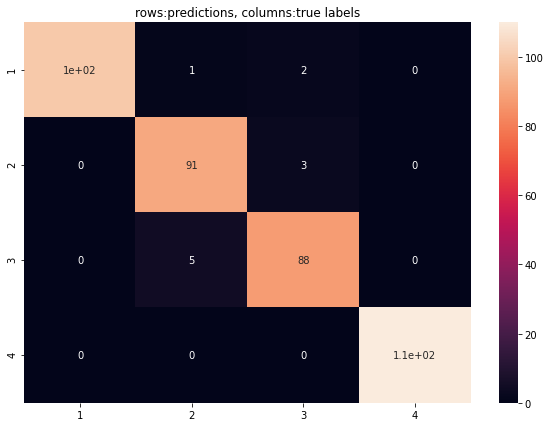

In [ ]:
print("coef=0.25")
Y_1_,preds_1_, accuracy_1_= acc_on_test_all(test_data_4,w_1_)
print("accuracy on test:",accuracy_1_)
plot_conf_mat_all(confusion_matrix_all(Y_1_,preds_1_))

print("coef=0.5")
Y_2_,preds_2_, accuracy_2_= acc_on_test_all(test_data_4,w_2_)
print("accuracy on test:",accuracy_2_)
plot_conf_mat_all(confusion_matrix_all(Y_2_,preds_2_))

print("coef=1")
Y_3_,preds_3_, accuracy_3_= acc_on_test_all(test_data_4,w_3_)
print("accuracy on test:",accuracy_3_)
plot_conf_mat_all(confusion_matrix_all(Y_3_,preds_3_))

print("coef=2")
Y_4_,preds_4_, accuracy_4_= acc_on_test_all(test_data_4,w_4_)
print("accuracy on test:",accuracy_4_)
plot_conf_mat_all(confusion_matrix_all(Y_4_,preds_4_))


The general view of the loss functions for different coefficients is similar to part b with regards to L2 regularizer.

Comparing L1 and L2, it can be seen from the plots that with same coefficients, L2 performs better than L1.